In [1]:
import torch
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from chirho.robust.internals.utils import ParamDict

pyro.settings.set(module_local_params=True)
sns.set_style("white")
pyro.set_rng_seed(315)  # for reproducibility

In [2]:
class ToyNormal(pyro.nn.PyroModule):
    def forward(self):
        mu = pyro.sample("mu", dist.Normal(0.0, 1.0))
        sd = pyro.sample("sd", dist.HalfNormal(1.0))
        return pyro.sample(
            "Y",
            dist.Normal(mu, scale=sd),
        )


class ToyNormalKnownSD(pyro.nn.PyroModule):
    def __init__(self, sd_true):
        super().__init__()
        self.sd_true = sd_true
    def forward(self):
        mu = pyro.sample("mu", dist.Normal(0.0, 1.0))
        return pyro.sample(
            "Y",
            dist.Normal(mu, scale=self.sd_true),
        )

class GroundTruthToyNormal(pyro.nn.PyroModule):
    def __init__(self, mu_true, sd_true):
        super().__init__()
        self.mu_true = mu_true
        self.sd_true = sd_true
    def forward(self):
        return pyro.sample(
            "Y",
            dist.Normal(self.mu_true, scale=self.sd_true),
        )

In [3]:
normal_pdf = lambda x, mu, sd: torch.exp(-0.5 * ((x - mu) / sd) ** 2) / (sd * math.sqrt(2.0 * math.pi))
normal_pdf_partial_sd = torch.func.grad(normal_pdf, argnums=2)


def fisher_eif_analytic(Y, mu, sd, known_sd):
    assert isinstance(mu, float)
    assert isinstance(sd, float)
    if known_sd:
        return torch.zeros(Y.shape[0])
    else:
        sd_torch = torch.tensor(sd, requires_grad=True)
        z_monte = sd * torch.randn(10000) + mu
        grad_functional = 2 * torch.tensor([normal_pdf_partial_sd(z, mu, sd_torch) for z in z_monte]).mean()
        inverse_fisher = sd ** 2 / 2
        score = ((Y - mu) ** 2) / (sd ** 3) - 1/sd
    return grad_functional * inverse_fisher * score


def kennedy_if_analytic(Y, mu, sd):
    assert isinstance(mu, float)
    assert isinstance(sd, float)
    pdf_at_y = normal_pdf(Y, mu, sd)
    z_monte = sd * torch.randn(100000)
    expected_density = torch.tensor([normal_pdf(z, mu, sd) for z in z_monte]).mean()
    return 2 * (pdf_at_y - expected_density)

# Analytic Influence Function & Efficient Influence Function

In [4]:
N_pts = 500
mu_true = 0.0
sd_true = 1.0
true_model = GroundTruthToyNormal(mu_true, sd_true)
D_pts = Predictive(true_model, num_samples=N_pts, return_sites=["Y"])()
Y_pts = D_pts["Y"]
Y_pts = torch.sort(Y_pts).values

fisher_pointwise = fisher_eif_analytic(Y_pts, mu_true, sd_true, False)
kennedy_pointwise = kennedy_if_analytic(Y_pts, mu_true, sd_true)
tangent_fn_pointwise = kennedy_pointwise - fisher_pointwise

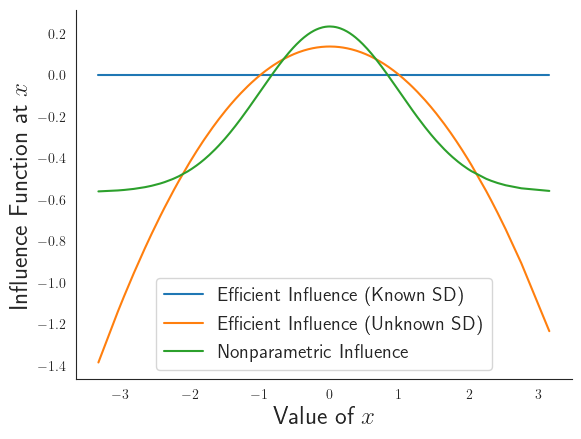

In [5]:
plt.rcParams['text.usetex'] = True
plt.plot(Y_pts, torch.zeros(Y_pts.shape[0]), label="Efficient Influence (Known SD)")
plt.plot(Y_pts, fisher_pointwise, label="Efficient Influence (Unknown SD)")
plt.plot(Y_pts, kennedy_pointwise, label="Nonparametric Influence")
# plt.plot(Y_pts, tangent_fn_pointwise, label="Tangent Nuisance Function")
plt.xlabel('Value of $x$', fontsize=18)
plt.ylabel('Influence Function at $x$', fontsize=18)
plt.legend(fontsize=14)
sns.despine()

In [6]:
# This should be close to zero since the tangent nuisance function 
# is orthogonal to the efficient influence function
fisher_pointwise.dot(tangent_fn_pointwise) / N_pts

tensor(-0.0043)

# Compare Analytic w/ Automated Influnce Functions

In [7]:
import functools
from chirho.robust.ops import influence_fn
from chirho.observational.handlers.predictive import PredictiveModel, PredictiveFunctional
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator

In [8]:
class MLEGuide(torch.nn.Module):
    def __init__(self, mle_est: ParamDict):
        super().__init__()
        self.names = list(mle_est.keys())
        for name, value in mle_est.items():
            setattr(self, name + "_param", torch.nn.Parameter(value))

    def forward(self, *args, **kwargs):
        for name in self.names:
            value = getattr(self, name + "_param")
            pyro.sample(
                name, pyro.distributions.Delta(value, event_dim=len(value.shape))
            )
            
class ExpectedDensity(torch.nn.Module):
    def __init__(self, model, *, num_monte_carlo: int = 10000):
        super().__init__()
        self.model = model
        self.log_marginal_prob = BatchedNMCLogMarginalLikelihood(model, num_samples=1)
        self.num_monte_carlo = num_monte_carlo

    def forward(self, *args, **kwargs):
        with pyro.plate("monte_carlo_functional", self.num_monte_carlo):
            points = PredictiveFunctional(self.model)(*args, **kwargs)

        log_marginal_prob_at_points = self.log_marginal_prob(points, *args, **kwargs)
        return torch.exp(
            torch.logsumexp(log_marginal_prob_at_points, dim=0)
            - math.log(self.num_monte_carlo)
        )

### With Inefficient Pointwise Computation

In [9]:
import time

In [10]:
functional = functools.partial(ExpectedDensity, num_monte_carlo=10000)

theta_true = {
    "mu": torch.nn.Parameter(torch.tensor(mu_true, requires_grad=True)), 
    "sd": torch.nn.Parameter(torch.tensor(sd_true, requires_grad=True))
}

model = ToyNormal()
guide = MLEGuide(theta_true)

with MonteCarloInfluenceEstimator(num_samples_outer=50000, num_samples_inner=1):
    with torch.no_grad():
        s_ = time.time()
        influence_fn_functional_og = influence_fn(functional, {'Y': Y_pts})
        influence_fn_estimator_og = influence_fn_functional_og(PredictiveModel(model, guide))
        monte_eif_og = influence_fn_estimator_og()
        print()
        print(f"Time taken: {(time.time() - s_) * 1000:.2f}ms")

CG Solve Progress: 2/2
Time taken: 923.44ms


### With Efficient Pointwise Computation

In [11]:
from chirho.robust.internals.full_linearize_from_left import full_linearize_from_left

functional = functools.partial(ExpectedDensity, num_monte_carlo=10000)

theta_true = {
    "mu": torch.nn.Parameter(torch.tensor(mu_true, requires_grad=True)), 
    "sd": torch.nn.Parameter(torch.tensor(sd_true, requires_grad=True))
}

model = ToyNormal()
guide = MLEGuide(theta_true)

with torch.no_grad():
    s_ = time.time()
    influence_fn_estimator_new = full_linearize_from_left(
        PredictiveModel(model, guide),
        functional=functional,
        num_samples_outer=50000,
        num_samples_inner=1,
        points_omit_latent_sites=True,
        remap_parameter_paths=True,
        ignore_params_not_requiring_grad=False,
        predictive_sites=("Y",),
    )
    monte_eif_new = influence_fn_estimator_new({'Y': Y_pts})
    print()
    print(f"Time taken: {(time.time() - s_) * 1000:.2f}ms")

CG Solve Progress: 1/2
Time taken: 28.60ms


In [12]:
# And, this maintains part of the computation and can reuse for new points.
D_pts_2 = Predictive(true_model, num_samples=N_pts, return_sites=["Y"])()
Y_pts_2 = torch.sort(D_pts_2["Y"]).values

with torch.no_grad():
    s_ = time.time()
    monte_eif_new_2nd = influence_fn_estimator_new({'Y': Y_pts_2})
    print()
    print(f"Time taken: {(time.time() - s_) * 1000:.2f}ms")


Time taken: 1.54ms


# Unknown Mean, Unknown SD

In [13]:
# FIXME need to pass x axis as well.
def plot_mceif_against_analytic(pts, monte_eif):
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.plot(Y_pts, fisher_pointwise, label='Analytic EIF', color='black')
    plt.scatter(pts, monte_eif.detach().numpy(), label='Monte Carlo EIF', alpha=.5)
    plt.xlabel('Value of $x$', fontsize=20)
    plt.xticks([])
    plt.ylabel('Influence Function at $x$', fontsize=20)
    plt.legend(fontsize=15)
    sns.despine()
    plt.tick_params(axis='y', labelsize=15)
    plt.tight_layout()

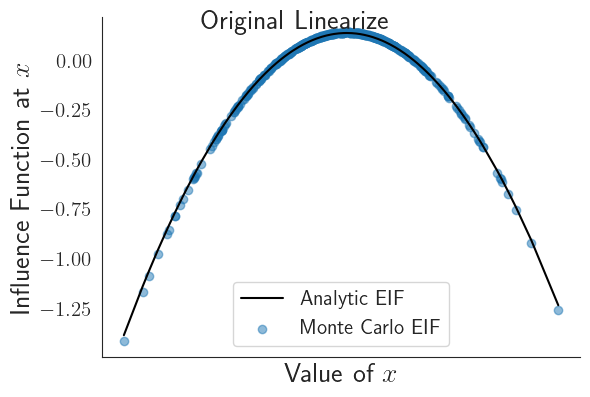

In [14]:
plot_mceif_against_analytic(Y_pts, monte_eif_og)
plt.suptitle('Original Linearize', fontsize=20)
pass

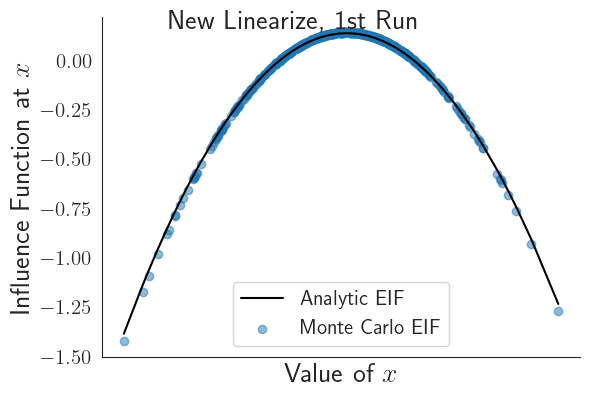

In [15]:
plot_mceif_against_analytic(Y_pts, monte_eif_new)
plt.suptitle('New Linearize, 1st Run', fontsize=20)
pass

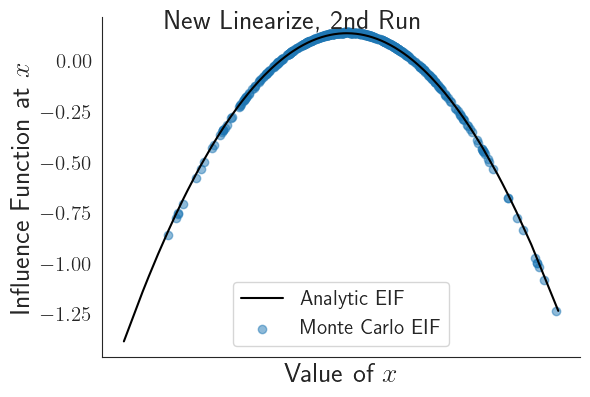

In [16]:
plot_mceif_against_analytic(Y_pts_2, monte_eif_new_2nd)
plt.suptitle('New Linearize, 2nd Run', fontsize=20)
pass